In [230]:
import librosa
from colorsys import rgb_to_hsv, hsv_to_rgb
import music21 as mu
from midi2audio import FluidSynth
import pandas as pd
import numpy as np
import sympy as sp
from IPython.display import HTML, IFrame
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.lines as lines
from matplotlib.patches import Rectangle
from IPython.display import Image
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib
import IPython


def create_sound_file_from_midi(m21_data, file_name):
    m21_data.write('midi', fp = file_name + ".mid")
    fs = FluidSynth()
    fs.midi_to_audio('./' + file_name + ".mid", file_name + '.mp3')
    return(IPython.display.Audio("./" + file_name + ".mp3"))



def complementary(r, g, b):
    hsv = rgb_to_hsv(r, g, b)
    return hsv_to_rgb((hsv[0] + 0.5) % 1, hsv[1], hsv[2])



enharmonicMap = {-1: "Rest", 
                 12: "C0", 13: "C#/Db0", 14: "D0", 15: "D#Eb0", 16: "E0", 17: "F0", 18: "F#Gb0", 19: "G0", 20: "G#Ab0", 21: "A0", 22: "A#/Bb0", 23: "B0",
                 24: "C1", 25: "C#/Db1", 26: "D1", 27: "D#Eb1", 28: "E1", 29: "F1", 30: "F#Gb1", 31: "G1", 32: "G#Ab1", 33: "A1", 34: "A#/Bb1", 35: "B1",
                 36: "C2", 37: "C#/Db2", 38: "D2", 39: "D#Eb2", 40: "E2", 41: "F2", 42: "F#Gb2", 43: "G2", 44: "G#Ab2", 45: "A2", 46: "A#/Bb2", 47: "B2",
                 48: "C3", 49: "C#/Db3", 50: "D3", 51: "D#Eb3", 52: "E3", 53: "F3", 54: "F#Gb3", 55: "G3", 56: "G#Ab3", 57: "A3", 58: "A#/Bb3", 59: "B3",
                 60: "C4", 61: "C#/Db4", 62: "D4", 63: "D#Eb4", 64: "E4", 65: "F4", 66: "F#Gb4", 67: "G4", 68: "G#Ab4", 69: "A4", 70: "A#/Bb4", 71: "B4",
                 72: "C5", 73: "C#/Db5", 74: "D5", 75: "D#Eb5", 76: "E5", 77: "F5", 78: "F#Gb5", 79: "G5", 80: "G#Ab5", 81: "A5", 82: "A#/Bb5", 83: "B5",
                 84: "C6", 85: "C#/Db6", 86: "D6", 87: "D#Eb6", 88: "E6", 89: "F6", 90: "F#Gb6", 91: "G6", 92: "G#Ab6", 93: "A6", 94: "A#/Bb6", 95: "B6",
                 96: "C7", 97: "C#/Db7", 98: "D7", 99: "D#Eb7", 100: "E7", 101: "F7", 102: "F#Gb7", 103: "G7", 104: "G#Ab7", 105: "A7", 106: "A#/Bb7", 107: "B7",
                 108: "C8", 109: "C#/Db8", 110: "D8", 111: "D#Eb8", 112: "E8", 113: "F8", 114: "F#Gb8", 115: "G8", 116: "G#Ab8", 117: "A8", 118: "A#/Bb8", 119: "B8",
                 120: "C9", 121: "C#/Db9", 122: "D9", 123: "D#Eb9", 124: "E9", 125: "F9", 126: "F#Gb9"
                }


def convertScoreToDF(scoreData = None, scoreName = None, scoreMovement = None):
    # examine the list of parts
    partList = scoreData.getElementsByClass(mu.stream.Part)
    pList = []
    for i in range(0, len(partList)):
        pList.append(partList[i])
        
        
    events = []

    currentNumerator = None
    currentDenominator = None
    currentInstrument = None
    currentInstrumentName = None
    currentPartName = None
    currentTempo = None

    for eachPart in pList:


        for el in eachPart.flatten():
            #print(el)

            eventDictionary = {}
            eventDictionary['offset'] = el.offset
            eventDictionary['quarterLengthDuration'] = el.duration.quarterLength
            eventDictionary['measureNumber'] = el.measureNumber
            eventDictionary['currentNumerator'] = currentNumerator
            eventDictionary['currentDenominator'] = currentDenominator
            eventDictionary['instrumentFamily'] = currentInstrumentName
            eventDictionary['part'] = currentPartName


            currentType = str(type(el))
            
            if currentType == "<class 'music21.tempo.MetronomeMark'>":
                currentTempo = el.number
                eventDictionary['currentTempo'] = currentTempo
            else:
                eventDictionary['currentTempo'] = currentTempo
                

            if currentType == "<class 'music21.meter.base.TimeSignature'>":

                currentNumerator = el.numerator
                currentDenominator = el.denominator

            if "instrument" in currentType:

                currentInstrumentName = el.instrumentName
                currentPartName = el.partName

            if currentType == "<class 'music21.note.Rest'>":
                #print("REST")
                eventDictionary['nameWithOctave'] = "NA"
                eventDictionary['midiNumber'] = -1
                eventDictionary['fullName'] = "Rest"
                eventDictionary['name'] = "NA"
                eventDictionary['octave'] = "NA"
                events.append(eventDictionary)


            if currentType == "<class 'music21.note.Note'>":
                eventDictionary['nameWithOctave'] = el.nameWithOctave
                eventDictionary['midiNumber'] = el.pitches[0].midi
                eventDictionary['fullName'] = el.pitches[0].fullName
                eventDictionary['name'] = el.pitches[0].name
                eventDictionary['octave'] = el.pitches[0].octave

                    
                events.append(eventDictionary)
     

            elif currentType == "<class 'music21.chord.Chord'>":
      

                for eachNote in el:
                    
                    tempEventDictionary = eventDictionary.copy()
                    tempEventDictionary['partOfChord'] = True
                    tempEventDictionary['nameWithOctave'] = eachNote.nameWithOctave
                    tempEventDictionary['midiNumber'] = eachNote.pitches[0].midi
                    tempEventDictionary['fullName'] = eachNote.pitches[0].fullName
                    tempEventDictionary['name'] = eachNote.pitches[0].name
                    tempEventDictionary['octave'] = eachNote.pitches[0].octave
                    tempEventDictionary['partOfChord'] = True

                    
                    events.append(tempEventDictionary)
           
                    
    scoreEventData = pd.DataFrame(events)
    scoreEventData['offsetAsFloat'] = scoreEventData['offset'].astype(float)
    scoreEventData['quarterLengthDurationAsFloat'] = scoreEventData.quarterLengthDuration.astype(float)
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(scoreEventData.part)))
    scoreEventData['partColor'] = colors.tolist()
    scoreEventData['scoreName'] = scoreName
    scoreEventData['movement'] = scoreMovement
    
    return(scoreEventData)






In [231]:
M1 = mu.converter.parse("./MidiAndMusicXMLFiles/MahlerSymphonies/symphony1/MusicXML/1st-movement-Langsam-Schleppend-Immer-sehr-gemachlich.mxl")
M2 = M1.stripTies()

In [233]:
M1Data = convertScoreToDF(M2, "MahlerSym1", 1)
M1Data['enharmonicEquivalency'] = M1Data.midiNumber.map(enharmonicMap)

In [234]:
M1Data.head().transpose()

,0,1,2,3,4
offset,0.0,4.0,8.0,12.0,16.0
quarterLengthDuration,4.0,4.0,4.0,4.0,4.0
measureNumber,1,2,3,4,5
currentNumerator,4,4,4,4,4
currentDenominator,4,4,4,4,4
instrumentFamily,Flute,Flute,Flute,Flute,Flute
part,"Flute, Fl�ten I II III IV","Flute, Fl�ten I II III IV","Flute, Fl�ten I II III IV","Flute, Fl�ten I II III IV","Flute, Fl�ten I II III IV"
currentTempo,240.0,62.0,62.0,62.0,62.0
nameWithOctave,NA,NA,NA,NA,NA
midiNumber,-1,-1,-1,-1,-1


In [235]:
M1Data.instrumentFamily.unique()

array(['Flute', 'Piccolo', 'Oboe', 'English Horn', 'B♭ Clarinet',
       'B♭ Bass Clarinet', 'Bassoon', 'Contrabassoon', 'Brass',
       'Horn in F', 'B♭ Trumpet', 'Trombone', 'Tuba', 'Timpani',
       'Acoustic Bass Drum', 'Harp', 'Strings', 'Contrabasses'],
      dtype=object)

In [236]:
M1Data.part.unique()

array(['Flute, Fl�ten I II III IV', 'Piccolo, Piccolo',
       'Oboe, Oboen I II III IV', 'English Horn, English Horn',
       'B♭ Clarinet, Clarinetti in B I II',
       'B♭ Clarinet, Klarinetten in C I II',
       'B♭ Clarinet, Klarinette in Eb',
       'B♭ Bass Clarinet, Bassklarinette in B',
       'Bassoon, Fagotte I II III', 'Contrabassoon, Kontrafagott',
       'Brass, H�rner in F I II', 'Horn in F, H�rner in F III IV',
       'Horn in F, H�rner in F V VI', 'Horn in F, H�rner in F VII',
       'B♭ Trumpet, Trompetten in F I II',
       'B♭ Trumpet, Trompetten in B III IV',
       'Trombone, Pausonen I II III', 'Tuba, Tuba', 'Timpani, Pauken',
       'Drumset, Becken', 'Drumset, Triangel', 'Timpani, Grosse trommel',
       'Harp, Harfe', 'Strings, Violine I', 'Strings, Violine II',
       'Strings, Viola', 'Strings, Violoncelle',
       'Contrabasses, Contrabasse'], dtype=object)

In [227]:

def createMatPlotLibAxisForScore(ax, x_limit, y_limit):    
    ax.set_xticks(range(int(x_limit)))
    ax.set_yticks(range(int(y_limit)))
    [ax.xaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(x_limit))]
    [ax.yaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(y_limit))]
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=.2)
    ax.tick_params(axis = "both", which = "both", bottom = False, top = False)
    
    return(ax)


def convertDataForScoreVisualisation(scoreDataAsDF, startMeasure, endMeasure):

    df1 = scoreDataAsDF[(scoreDataAsDF.measureNumber >= startMeasure) & (scoreDataAsDF.measureNumber <= endMeasure) & (scoreDataAsDF.midiNumber != -1)]

    offsetForStart = min(df1.offsetAsFloat)
    minMidiNumber = min(df1.midiNumber)
    maxMidiNumber = max(df1.midiNumber)

    # get needed columns
    df2 = df1[["instrumentFamily", "part","measureNumber", "offsetAsFloat", "midiNumber", "enharmonicEquivalency", "quarterLengthDurationAsFloat", "partColor"]].copy().reset_index()

    # assing a standard hgiht
    df2['height'] = 1

    # find out how many instruments sharing width
    heightNormalize = df2.groupby(by=["offsetAsFloat", "midiNumber"]).sum().reset_index()[['offsetAsFloat', 'midiNumber', 'height']]
    df3 = pd.merge(df2, heightNormalize,  how='left', left_on=['offsetAsFloat','midiNumber'], right_on = ['offsetAsFloat','midiNumber'])


    # Reset and create width of instruments
    df4 = df3.sort_values(by = [ "offsetAsFloat", "midiNumber"]).reset_index()
    df4['width'] = df4.height_x / df4.height_y



    df5 = df4[df4.width == 1].reset_index(drop=True)
    df5["verticalOrder"] = 0
    df5["tempOffsetMidi"] = "NA"
    df5['adjustedHeightOffset'] = 0

    # Select Reset and create offset
    df6 = df4[df4.width <1].reset_index(drop=True)


    df6['tempOffSetMidi'] = df6['offsetAsFloat'].astype(str) + "___" +  df6['midiNumber'].astype(str)
    df6["verticalOrder"] = df6.groupby((df6["tempOffSetMidi"]!=df6["tempOffSetMidi"].shift()).cumsum()).cumcount()+1
    df6['adjustedHeightOffset'] = (df6.width * df6.verticalOrder) - df6.width

    df7 = pd.concat([df5, df6])
    df7['new_col'] = list(zip(df7["offsetAsFloat"]-offsetForStart, (df7["midiNumber"] - minMidiNumber) + df7['adjustedHeightOffset'] ))
    df7['col2'] = list(zip(df7["new_col"], df7["quarterLengthDurationAsFloat"], df7["width"], df7["partColor"], df7["enharmonicEquivalency"]))
    
    
    coords = df7.col2.values

    return([coords, minMidiNumber, maxMidiNumber, df7])


def createScoreFormatting(ax1, yOffset):
    
    # formatting data
    text_kwargs = dict( fontsize=32, color='white')
    
    keyColorCoords = [((0, 1), 80, 1), ((0, 3), 80, 1), ((0, 6), 80, 1), ((0, 8), 80, 1), ((0, 10), 80, 1), 
                 ((0, 13), 80, 1),((0, 15), 80, 1),((0, 18), 80, 1),((0, 20), 80, 1),((0, 22), 80, 1),
                 ((0, 25), 80, 1), ((0, 27), 80, 1), ((0, 30), 80, 1), ((0, 32), 80, 1), ((0, 34), 80, 1),
                 ((0, 37), 80, 1), ((0, 39), 80, 1), ((0, 42), 80, 1), ((0, 44), 80, 1), ((0, 46), 80, 1),
                 ((0, 49), 80, 1), ((0, 51), 80, 1), ((0, 54), 80, 1), ((0, 56), 80, 1), ((0, 58), 80, 1),
                 ((0, 61), 80, 1), ((0, 63), 80, 1), ((0, 66), 80, 1), ((0, 68), 80, 1), ((0, 70), 80, 1),
                 ((0, 73), 80, 1), ((0, 75), 80, 1), ((0, 78), 80, 1), ((0, 80), 80, 1), ((0, 82), 80, 1),
                 ((0, 85), 80, 1), ((0, 87), 80, 1), ((0, 90), 80, 1), ((0, 92), 80, 1), ((0, 94), 80, 1),
                 ((0, 97), 80, 1), ((0, 99), 80, 1), ((0, 102), 80, 1), ((0, 104), 80, 1), ((0, 106), 80, 1),
                 ((0, 109), 80, 1), ((0, 111), 80, 1), ((5, 114), 80, 1), ((0, 116), 80, 1), ((0, 118), 80, 1)]


    # color="#EBECF0"
    # Draw black and white keys
    [ax1.add_patch(Rectangle((keyColorCoords[i][0][0],keyColorCoords[i][0][1] - yOffset), keyColorCoords[i][1], keyColorCoords[i][2], facecolor="#bfc2cf", edgecolor = "white", zorder = -10)) for i in range(len(keyColorCoords))]

    ax1.add_patch(Rectangle((0, 0), 48, 1, color = "black"))
    

    return(ax1)



def visualizeScore(scoreData, fromMeasure = None, toMeasure = None, reduce = False):
    
    coords1 = convertDataForScoreVisualisation(scoreData, fromMeasure, toMeasure)

    text_kwargs = dict( fontsize=10, color='white')

    legend_elements = [Line2D([0], [0], color='b', lw=4, label='Violin'),
                       Line2D([0], [0], marker='o', color='w', label='Viola',
                              markerfacecolor='g', markersize=15),
                       Patch(facecolor='orange', edgecolor='r',
                             label='Cello')]



    # DRAW NOTES
    fig, (ax1) = plt.subplots(1, 1, figsize=(45, 20))
   
    
    #plt.figure(dpi = 400)

    ax1 = createMatPlotLibAxisForScore(ax1, 48, (coords1[2] - coords1[1]) + 5)

    t = [ax1.add_patch(Rectangle(coords1[0][i][0], coords1[0][i][1], coords1[0][i][2], color = coords1[0][i][3])) for i in range(len(coords1[0]))]

    u = [ax1.text(coords1[0][j][0][0] + .1, coords1[0][j][0][1] + .1, coords1[0][j][4], **text_kwargs) for j in range(len(coords1[0]))]
    
    
    
    # Add measure numbers
    measureNumberPositions = scoreData.loc[scoreData.groupby('measureNumber').offsetAsFloat.idxmin()].reset_index()[['measureNumber', 'offsetAsFloat']]
    measureNumberPositions2 = measureNumberPositions[( measureNumberPositions.measureNumber >= fromMeasure) & ( measureNumberPositions.measureNumber <= toMeasure) ]
    minOffSet = min(measureNumberPositions2.offsetAsFloat)
    [ax1.text((measureNumberPositions2.offsetAsFloat.values[i] - minOffSet) + .2, .15, measureNumberPositions2.measureNumber.values[i], fontsize = 17, color='white') for i in range(len(measureNumberPositions2.offsetAsFloat.values))]
    
    # Add bar lines
    [ax1.add_artist(lines.Line2D([measureNumberPositions2.offsetAsFloat.values[i] - minOffSet, measureNumberPositions2.offsetAsFloat.values[i] - minOffSet], [0, 80], lw = 5)) for i in  range(len(measureNumberPositions2.offsetAsFloat.values))]


    ax1.legend(handles=legend_elements, loc='upper right')

    f1 = createScoreFormatting(ax1, coords1[1])
    
   
    # clean standard instrument and part names
    # offset for stuff at bottom
    # create simple chords
    # put in tempo
    # create the legend

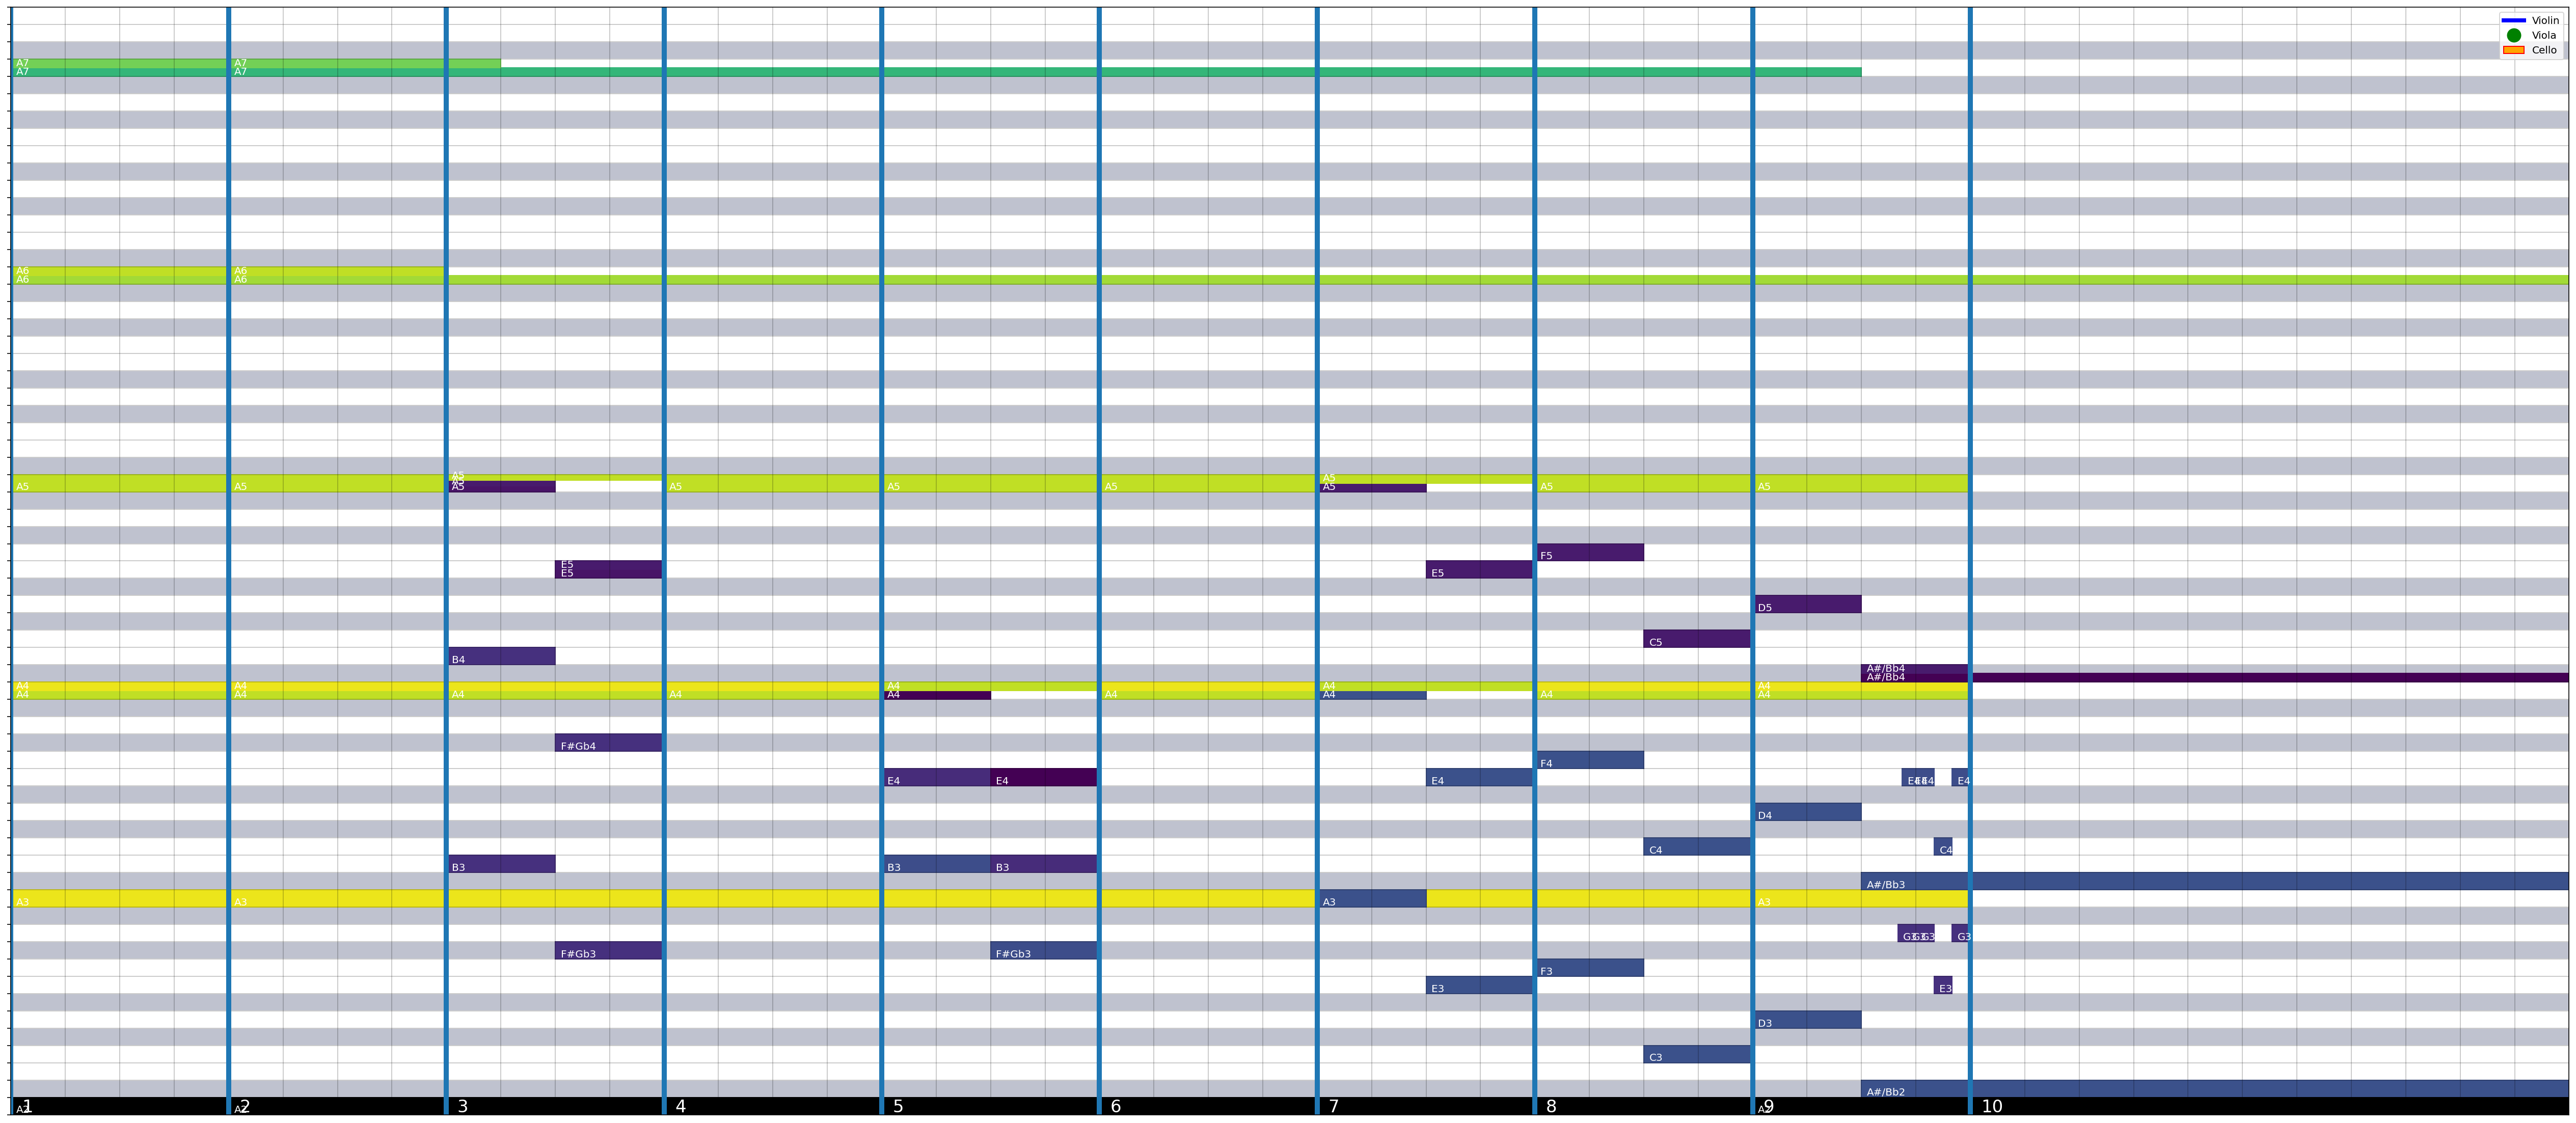

In [229]:
visualizeScore(M1Data, 0, 10)

In [75]:
M1Data

,offset,quarterLengthDuration,measureNumber,currentNumerator,currentDenominator,instrumentFamily,part,currentTempo,nameWithOctave,midiNumber,fullName,name,octave,partOfChord,offsetAsFloat,quarterLengthDurationAsFloat,partColor,scoreName,movement
0,0.0,4.0,1,4,4,Flute,"Flute, Fl�ten I II III IV",240.0,NA,-1,Rest,NA,NA,NaN,0.000000,4.000,"[0.267004, 0.004874, 0.329415, 1.0]",MahlerSym1,1
1,4.0,4.0,2,4,4,Flute,"Flute, Fl�ten I II III IV",62.0,NA,-1,Rest,NA,NA,NaN,4.000000,4.000,"[0.267004, 0.004874, 0.329415, 1.0]",MahlerSym1,1
2,8.0,4.0,3,4,4,Flute,"Flute, Fl�ten I II III IV",62.0,NA,-1,Rest,NA,NA,NaN,8.000000,4.000,"[0.267004, 0.004874, 0.329415, 1.0]",MahlerSym1,1
3,12.0,4.0,4,4,4,Flute,"Flute, Fl�ten I II III IV",62.0,NA,-1,Rest,NA,NA,NaN,12.000000,4.000,"[0.267004, 0.004874, 0.329415, 1.0]",MahlerSym1,1
4,16.0,4.0,5,4,4,Flute,"Flute, Fl�ten I II III IV",62.0,NA,-1,Rest,NA,NA,NaN,16.000000,4.000,"[0.267004, 0.004874, 0.329415, 1.0]",MahlerSym1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,1055527/480,0.125,550,2,2,Contrabasses,"Contrabasses, Contrabasse",200.0,NA,-1,Rest,NA,NA,NaN,2199.014583,0.125,"[0.993248, 0.906157, 0.143936, 1.0]",MahlerSym1,1
39997,1055587/480,0.375,550,2,2,Contrabasses,"Contrabasses, Contrabasse",200.0,A2,45,A-natural in octave 2,A,2,NaN,2199.139583,0.375,"[0.993248, 0.906157, 0.143936, 1.0]",MahlerSym1,1
39998,1055767/480,0.5,550,2,2,Contrabasses,"Contrabasses, Contrabasse",200.0,NA,-1,Rest,NA,NA,NaN,2199.514583,0.500,"[0.993248, 0.906157, 0.143936, 1.0]",MahlerSym1,1
39999,1056007/480,2.0,551,2,2,Contrabasses,"Contrabasses, Contrabasse",200.0,D3,50,D-natural in octave 3,D,3,NaN,2200.014583,2.000,"[0.993248, 0.906157, 0.143936, 1.0]",MahlerSym1,1


In [61]:
M1Data.groupby(by=["measureNumber", "offsetAsFloat"]).count().head(5).reset_index()

,measureNumber,offsetAsFloat,offset,quarterLengthDuration,currentNumerator,currentDenominator,instrumentFamily,part,currentTempo,nameWithOctave,midiNumber,fullName,name,octave,partOfChord,quarterLengthDurationAsFloat,partColor,scoreName,movement
0,1,0.0,30,30,30,30,30,30,30,30,30,30,30,30,0,30,30,30,30
1,2,4.0,34,34,34,34,34,34,34,34,34,34,34,34,5,34,34,34,34
2,3,8.0,34,34,34,34,34,34,34,34,34,34,34,34,5,34,34,34,34
3,4,12.0,28,28,28,28,28,28,28,28,28,28,28,28,4,28,28,28,28
4,4,13.0,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2


In [64]:
M1Data.loc[M1Data.groupby('measureNumber').offsetAsFloat.idxmin()][['measureNumber', 'offsetAsFloat']]

,measureNumber,offsetAsFloat
0,1,0.0
1,2,4.0
2,3,8.0
3,4,12.0
4,5,16.0
...,...,...
2122,547,2184.0
2126,548,2188.0
2127,549,2192.0
2132,550,2196.0
